In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
import train

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 10)

In [2]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [3]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')


def load_data(raw, dataset='', validation=False):
    '''
    Return dataframe matching data set and validation. Dictionary input will be updated.

    Parameters
    ----------
    raw : dict
        dictionary which caches the dataframes and will be updated accordingly

    dataset : str
        which dataset to use? valid input includes: empty str for full set, sample_, and secret_

    validation : bool
        load validation set? if true then use _test, otherwise use _train.  Note secret_ doesn't have _train
    '''
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t4_data/{key}.pkl')
    return raw[key]

In [4]:
configurations = {
    'dataset' : 'sample_', # '', 'sample_', 'secret_'
    'model_identifier' : "GOLD_FULL",
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t4_models",
    'train_params' : {
        'batch_size': 50000,
        'shuffle': True,
        'num_workers': 3,
        'pin_memory': True,
    },
    'test_params' : {
        'batch_size': 200000,
        'num_workers': 2,
        'pin_memory': True,
    },
}

In [5]:
%%time

train_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=configurations['dataset'],validation=False))
test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=configurations['dataset'],validation=True))

train_df = train_df.dropna()
test_df = test_df.dropna()
# train_df = train_df.sample(100000, random_state=42)
# test_df = test_df.sample(10000, random_state=42)

Loading data to cache for: sample_train
Loading data to cache for: sample_test
CPU times: user 782 ms, sys: 577 ms, total: 1.36 s
Wall time: 1.04 s


In [6]:
ref_train, X_train, y_train = get_ref_X_y(train_df)
ref_test, X_test, y_test = get_ref_X_y(test_df)

In [7]:
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_RA_OF_ASC_NODE', 'y_ARG_OF_PERICENTER_REG', 'y_ARG_OF_PERICENTER', 'y_BSTAR', 'y_REV_MA_REG', 'y_MEAN_ANOMALY']
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_ARG_OF_PERICENTER_REG', 'y_REV_MA_REG']
# y_cols = ['y_REV_MA_REG']
y_train = y_train[y_cols]
y_test = y_test[y_cols]

# y_train = np.sign(y_train) * np.log(1+np.abs(y_train))
# y_test = np.sign(y_test) * np.log(1+np.abs(y_test))

In [8]:
# model, mean_losses = train.train_model(X_train, y_train, X_test, y_test, configurations, force_train=False)

Loading existing model


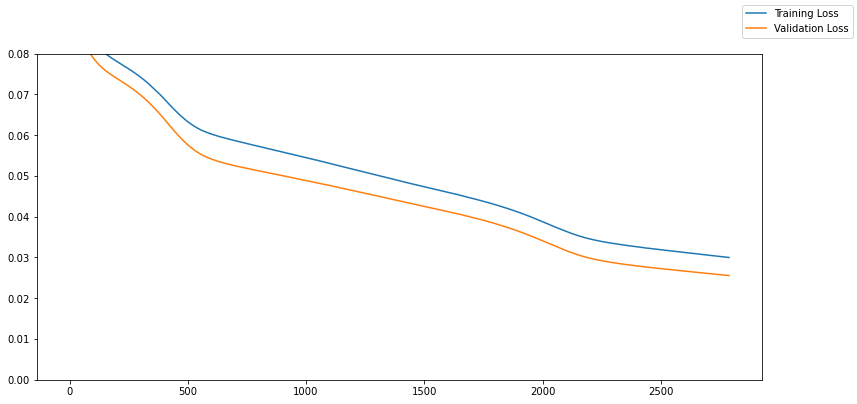

In [9]:
model, _, _, mean_losses, _ = train.load_model_with_config(configurations)

tl, vl = zip(*mean_losses)

fig,ax = plt.subplots(figsize=(13,6))
ax.plot(tl, label="Training Loss")
ax.plot(vl, label="Validation Loss")
plt.ylim(0, 0.08)
fig.legend()
plt.show()

In [10]:
mean_losses[-50:]

[(0.030319692411770422, 0.025847269222140312),
 (0.030312092198679846, 0.025841088965535164),
 (0.030302091501653194, 0.02583630383014679),
 (0.030297184828668833, 0.025829432532191277),
 (0.03029307210817933, 0.025823889300227165),
 (0.03028021116430561, 0.02581852674484253),
 (0.030290619780619938, 0.025812778621912003),
 (0.030275048377613228, 0.02580586075782776),
 (0.030262896946320932, 0.025801941752433777),
 (0.03026854262376825, 0.025795618072152138),
 (0.03024912935992082, 0.025788793340325356),
 (0.03024427794540922, 0.02578456699848175),
 (0.030235177061210077, 0.025777412578463554),
 (0.030231324024498463, 0.02577371709048748),
 (0.030240817461162806, 0.025766760110855103),
 (0.030217866102854412, 0.02576018124818802),
 (0.030215688981115818, 0.02575492300093174),
 (0.030211653870840866, 0.025749778375029564),
 (0.030213376662383478, 0.02574346214532852),
 (0.03020022079969446, 0.025738419964909554),
 (0.03019695372010271, 0.025732822716236115),
 (0.030179852930208046, 0.02

In [11]:
trained_model = model
sample_idx = random.sample(list(X_test.index), 10000)

X_sample = X_test.loc[sample_idx]
y_sample = y_test.loc[sample_idx]
# y_train_pred = train.predict(trained_model, X_train, y_train, device="cpu") # get predictions for each train
# y_train_pred_df = pd.DataFrame(y_train_pred, columns=y_train.columns)  # put results into a dataframe
y_sample_pred = train.predict(trained_model, X_sample, y_sample, device="cpu") # get predictions for each train
y_sample_pred_df = pd.DataFrame(y_sample_pred, columns=y_sample.columns, index=y_sample.index)  # put results into a dataframe

In [12]:
print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_sample, y_sample_pred_df)}')
print(f'    Test set MSE (L2) loss: {mean_squared_error(y_sample, y_sample_pred_df)}')

# random.seed(342798)
sample = random.sample(list(y_sample_pred_df.index), 10)
# sample = [0,1]

print("Test - Ground Truth (normalized):")
display(y_sample)
print("Test - Prediction (normalized):")
display(y_sample_pred_df)
# print("Ground Truth Diffs from X_:")
# display(y_sample - X_sample[['X_INCLINATION_1','X_ECCENTRICITY_1','X_MEAN_MOTION_1']].values)
# print("Pred Diffs from X_:")
# display(y_sample_pred_df - X_sample[['X_INCLINATION_1','X_ECCENTRICITY_1','X_MEAN_MOTION_1']].values)


    Test set MAE (L1) loss: 0.08761642827752959
    Test set MSE (L2) loss: 0.025523485939101295
Test - Ground Truth (normalized):


,y_INCLINATION,y_ECCENTRICITY,y_MEAN_MOTION,y_RA_OF_ASC_NODE_REG,y_ARG_OF_PERICENTER_REG,y_REV_MA_REG
66993,0.5487933333,0.0400896,0.3392912937,0.1710011111,0.5547369444,1.0382722006
15558,0.3690255556,0.1696620,0.3055841851,0.5966633333,0.7466586111,0.4693348858
58551,0.5486383333,0.0402800,0.3392524446,0.3380163889,0.9742111111,0.2225067716
35031,0.1612744444,0.0996360,0.4028953566,0.1322194444,0.8987191667,0.1677421975
10768,0.3690400000,0.1067196,0.3606225006,0.4742605556,0.8566277778,0.1681899506
...,...,...,...,...,...,...
9202,0.3689655556,0.1426424,0.3269632366,0.6653711111,0.7559288889,0.2914781049
44565,0.5502911111,0.0716060,0.3590859897,0.3762030556,0.9691413889,0.2336677593
43336,0.5496688889,0.0666608,0.4936971737,0.4250527778,0.9285000000,0.8563274969
70756,0.5502522222,0.0139128,0.3252446434,0.3074213889,0.1448147222,0.3223925525


Test - Prediction (normalized):


,y_INCLINATION,y_ECCENTRICITY,y_MEAN_MOTION,y_RA_OF_ASC_NODE_REG,y_ARG_OF_PERICENTER_REG,y_REV_MA_REG
66993,0.5455887318,0.0583449565,0.3309842944,0.0821642280,0.6525836587,0.7151121497
15558,0.3617717028,0.1482646465,0.3189350665,0.5729538202,0.7580994368,0.5633443594
58551,0.5488431454,-0.0098722726,0.3591923118,0.6272080541,0.6434558034,0.3412408531
35031,0.1519111246,0.0396008156,0.4282726943,0.5264076591,0.4466510415,0.4511311054
10768,0.3653993011,0.0522770174,0.3838598430,0.6026685238,0.7170697451,0.4635632038
...,...,...,...,...,...,...
9202,0.3615422845,0.1003063321,0.3469024897,0.5844838619,0.8138972521,0.5593342781
44565,0.5477895141,0.0214923322,0.3799783289,0.6378611922,0.6786749363,0.3457528353
43336,0.5446594954,0.0568659902,0.4867762625,0.3946493864,0.8057019711,0.3487168252
70756,0.5501464009,-0.0245166644,0.3446531296,0.0939509720,0.5698630810,0.3440833986


In [ ]:
# Epoch 2790 switch to full training set